In [1]:
# # 06 - Hyperparameter Tuning
# ## Optimizing Model Performance
# 
# ### Objectives:
# - Use GridSearchCV for exhaustive search
# - Use RandomizedSearchCV for efficient search
# - Compare optimized models with baseline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, classification_report)
import joblib
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load data and previous results
X_selected = pd.read_csv('data/heart_disease_selected_features.csv')
y_clean = pd.read_csv('data/heart_disease_cleaned_target.csv')['target']
previous_results = joblib.load('models/all_models_results.pkl')

print("Data and previous results loaded successfully!")

Data and previous results loaded successfully!


In [7]:
def perform_hyperparameter_tuning(X, y, previous_results):
    """Perform hyperparameter tuning for the best model"""
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Identify the best model from previous results
    best_model_name = max(previous_results.items(), 
                         key=lambda x: x[1]['accuracy'])[0]
    best_model_accuracy = previous_results[best_model_name]['accuracy']
    
    print(f"Best model from previous training: {best_model_name}")
    print(f"Baseline accuracy: {best_model_accuracy:.4f}")
    
    # Define parameter grids for each model
    param_grids = {
        'Logistic Regression': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2', 'elasticnet'],
            'solver': ['liblinear', 'saga'],
            'l1_ratio': [0.1, 0.5, 0.9]  # for elasticnet
        },
        
        'Decision Tree': {
            'max_depth': [3, 5, 7, 10, 15, 20, None],
            'min_samples_split': [2, 5, 10, 15],
            'min_samples_leaf': [1, 2, 4, 6],
            'criterion': ['gini', 'entropy'],
            'max_features': ['sqrt', 'log2', None]
        },
        
        'Random Forest': {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False],
            'max_features': ['sqrt', 'log2', None]
        },
        
        'SVM': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto', 0.1, 1, 10],
            'degree': [2, 3, 4]  # for poly kernel
        }
    }
    
    # Select the appropriate model and parameter grid
    if best_model_name == 'Logistic Regression':
        model = LogisticRegression(max_iter=1000, random_state=42)
        param_grid = param_grids['Logistic Regression']
    elif best_model_name == 'Decision Tree':
        model = DecisionTreeClassifier(random_state=42)
        param_grid = param_grids['Decision Tree']
    elif best_model_name == 'Random Forest':
        model = RandomForestClassifier(random_state=42)
        param_grid = param_grids['Random Forest']
    else:  # SVM
        model = SVC(probability=True, random_state=42)
        param_grid = param_grids['SVM']
    
    print(f"\nPerforming GridSearchCV for {best_model_name}...")
    print("=" * 60)
    
    # GridSearchCV for exhaustive search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Get best parameters and model
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_
    
    # Evaluate tuned model
    y_pred_tuned = best_estimator.predict(X_test)
    y_pred_proba_tuned = best_estimator.predict_proba(X_test)[:, 1]
    
    accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
    precision_tuned = precision_score(y_test, y_pred_tuned)
    recall_tuned = recall_score(y_test, y_pred_tuned)
    f1_tuned = f1_score(y_test, y_pred_tuned)
    auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)
    
    # Compare with baseline
    improvement = accuracy_tuned - best_model_accuracy
    
    print(f"\nHyperparameter Tuning Results for {best_model_name}")
    print("=" * 60)
    print(f"Best Parameters: {best_params}")
    print(f"Baseline Accuracy: {best_model_accuracy:.4f}")
    print(f"Tuned Accuracy: {accuracy_tuned:.4f}")
    print(f"Improvement: {improvement:.4f}")
    print(f"Precision: {precision_tuned:.4f}")
    print(f"Recall: {recall_tuned:.4f}")
    print(f"F1-Score: {f1_tuned:.4f}")
    print(f"AUC: {auc_tuned:.4f}")
    
    return (best_estimator, best_params, improvement, 
            accuracy_tuned, precision_tuned, recall_tuned, f1_tuned, auc_tuned,
            best_model_name, best_model_accuracy)

In [9]:
# Perform hyperparameter tuning
(tuned_model, best_params, improvement, 
 accuracy_tuned, precision_tuned, recall_tuned, f1_tuned, auc_tuned,
 best_model_name, baseline_accuracy) = perform_hyperparameter_tuning(X_selected, y_clean, previous_results)

Best model from previous training: Logistic Regression
Baseline accuracy: 0.8525

Performing GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Hyperparameter Tuning Results for Logistic Regression
Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Baseline Accuracy: 0.8525
Tuned Accuracy: 0.8525
Improvement: 0.0000
Precision: 0.8065
Recall: 0.8929
F1-Score: 0.8475
AUC: 0.9329


In [11]:
def visualize_tuning_results(baseline_results, tuned_results, best_model_name):
    """Visualize the improvement after hyperparameter tuning"""
    
    # Baseline metrics
    baseline_metrics = [
        baseline_results['accuracy'],
        baseline_results['precision'],
        baseline_results['recall'],
        baseline_results['f1'],
        baseline_results['auc']
    ]
    
    # Tuned metrics
    tuned_metrics = [
        tuned_results['accuracy'],
        tuned_results['precision'], 
        tuned_results['recall'],
        tuned_results['f1'],
        tuned_results['auc']
    ]
    
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
    
    # Create comparison plot
    plt.figure(figsize=(12, 8))
    
    x_pos = np.arange(len(metrics_names))
    width = 0.35
    
    plt.bar(x_pos - width/2, baseline_metrics, width, 
            label='Baseline', alpha=0.7, color='skyblue')
    plt.bar(x_pos + width/2, tuned_metrics, width, 
            label='Tuned', alpha=0.7, color='lightcoral')
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title(f'Performance Comparison: Baseline vs Tuned {best_model_name}')
    plt.xticks(x_pos, metrics_names)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.ylim(0, 1)
    
    # Add value labels
    for i, v in enumerate(baseline_metrics):
        plt.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)
    for i, v in enumerate(tuned_metrics):
        plt.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print("\nDetailed Performance Comparison:")
    print("=" * 50)
    comparison_df = pd.DataFrame({
        'Metric': metrics_names,
        'Baseline': baseline_metrics,
        'Tuned': tuned_metrics,
        'Improvement': np.array(tuned_metrics) - np.array(baseline_metrics)
    })
    print(comparison_df.round(4))

In [13]:
# Prepare results for visualization
baseline_results = previous_results[best_model_name]
tuned_results = {
    'accuracy': accuracy_tuned,
    'precision': precision_tuned,
    'recall': recall_tuned, 
    'f1': f1_tuned,
    'auc': auc_tuned
}

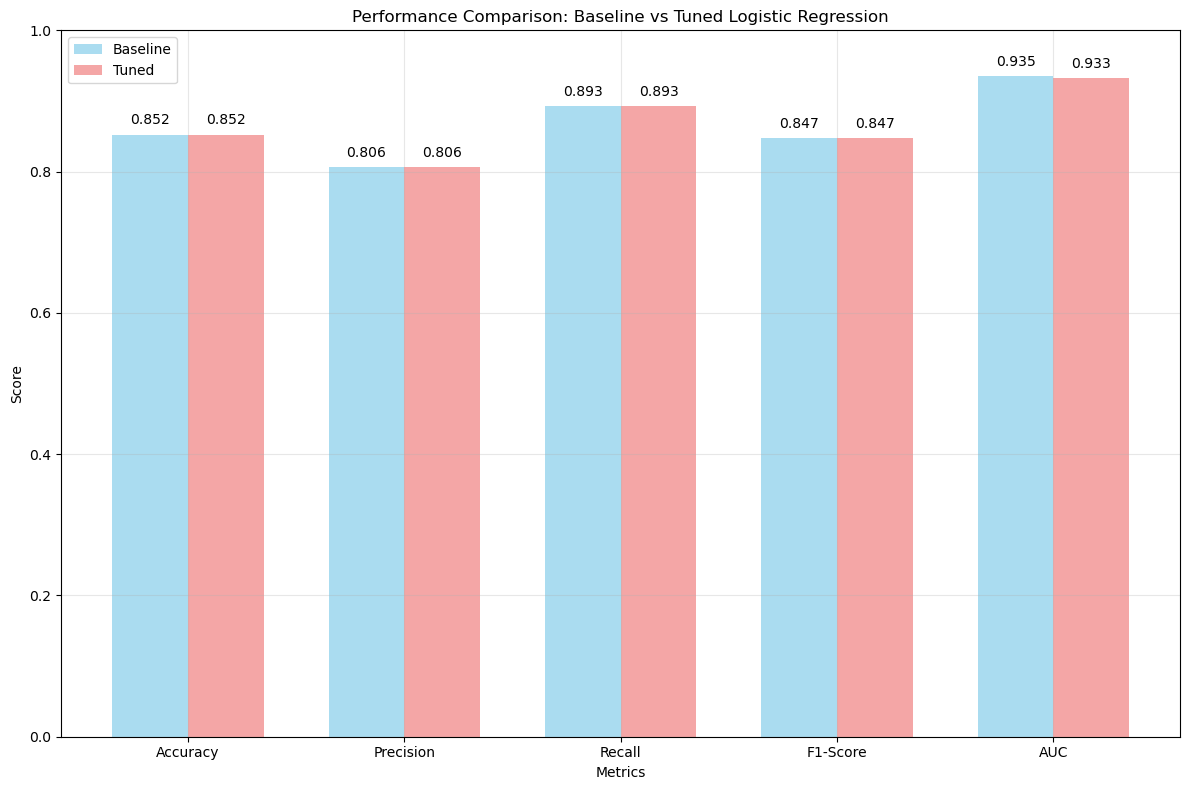


Detailed Performance Comparison:
      Metric  Baseline   Tuned  Improvement
0   Accuracy    0.8525  0.8525       0.0000
1  Precision    0.8065  0.8065       0.0000
2     Recall    0.8929  0.8929       0.0000
3   F1-Score    0.8475  0.8475       0.0000
4        AUC    0.9351  0.9329      -0.0022


In [15]:
# Visualize results
visualize_tuning_results(baseline_results, tuned_results, best_model_name)

In [17]:
def perform_randomized_search(X, y, best_model_name):
    """Perform RandomizedSearchCV for comparison"""
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Define parameter distributions for randomized search
    param_distributions = {
        'Logistic Regression': {
            'C': np.logspace(-3, 2, 100),
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        },
        
        'Random Forest': {
            'n_estimators': np.arange(50, 500, 50),
            'max_depth': [3, 5, 7, 10, 15, 20, None],
            'min_samples_split': np.arange(2, 20, 2),
            'min_samples_leaf': np.arange(1, 10, 1),
            'max_features': ['sqrt', 'log2', None]
        },
        
        'SVM': {
            'C': np.logspace(-2, 3, 100),
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto'] + list(np.logspace(-3, 1, 50))
        }
    }
    
    # Select appropriate model
    if best_model_name == 'Logistic Regression':
        model = LogisticRegression(max_iter=1000, random_state=42)
        param_dist = param_distributions['Logistic Regression']
    elif best_model_name == 'Random Forest':
        model = RandomForestClassifier(random_state=42)
        param_dist = param_distributions['Random Forest']
    else:  # SVM
        model = SVC(probability=True, random_state=42)
        param_dist = param_distributions['SVM']
    
    print(f"\nPerforming RandomizedSearchCV for {best_model_name}...")
    print("=" * 60)
    
    randomized_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=50,  # Number of parameter settings sampled
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    randomized_search.fit(X_train, y_train)
    
    print(f"Best score (RandomizedSearchCV): {randomized_search.best_score_:.4f}")
    print(f"Best parameters: {randomized_search.best_params_}")
    
    return randomized_search

In [19]:
# Perform randomized search for comparison
randomized_search = perform_randomized_search(X_selected, y_clean, best_model_name)


Performing RandomizedSearchCV for Logistic Regression...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best score (RandomizedSearchCV): 0.8346
Best parameters: {'solver': 'saga', 'penalty': 'l1', 'C': 0.4229242874389499}


In [21]:
# Save the tuned model and results
tuning_results = {
    'tuned_model': tuned_model,
    'best_params': best_params,
    'improvement': improvement,
    'best_model_name': best_model_name,
    'randomized_search': randomized_search
}

joblib.dump(tuned_model, 'models/tuned_best_model.pkl')
joblib.dump(tuning_results, 'models/hyperparameter_tuning_results.pkl')

print("\nHyperparameter tuning completed!")
print(f"Best model: {best_model_name}")
print(f"Improvement: {improvement:.4f}")
print("Tuned model saved as 'models/tuned_best_model.pkl'")


Hyperparameter tuning completed!
Best model: Logistic Regression
Improvement: 0.0000
Tuned model saved as 'models/tuned_best_model.pkl'


In [27]:
# Save evaluation metrics to file
def save_evaluation_metrics(baseline_results, tuned_results, best_model_name, 
                          best_params, improvement, filename='evaluation_metrics.txt'):
    """Save evaluation metrics to a text file"""
    
    with open(filename, 'w') as f:
        f.write("HYPERPARAMETER TUNING EVALUATION METRICS\n")
        f.write("=" * 50 + "\n\n")
        
        f.write(f"Best Model: {best_model_name}\n")
        f.write(f"Improvement: {improvement:.4f}\n\n")
        
        f.write("Best Parameters:\n")
        for param, value in best_params.items():
            f.write(f"  {param}: {value}\n")
        f.write("\n")
        
        f.write("Performance Metrics Comparison:\n")
        f.write("-" * 40 + "\n")
        f.write(f"{'Metric':<12} {'Baseline':<10} {'Tuned':<10} {'Improvement':<12}\n")
        f.write("-" * 40 + "\n")
        
        metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
        metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
        
        for metric, name in zip(metrics, metric_names):
            baseline_val = baseline_results[metric]
            tuned_val = tuned_results[metric]
            improvement_val = tuned_val - baseline_val
            
            f.write(f"{name:<12} {baseline_val:<10.4f} {tuned_val:<10.4f} {improvement_val:<12.4f}\n")
        
        f.write("-" * 40 + "\n\n")
        
        f.write("Detailed Analysis:\n")
        f.write(f"- Baseline accuracy: {baseline_results['accuracy']:.4f}\n")
        f.write(f"- Tuned accuracy: {tuned_results['accuracy']:.4f}\n")
        f.write(f"- Absolute improvement: {improvement:.4f}\n")
        f.write(f"- Relative improvement: {(improvement/baseline_results['accuracy'])*100:.2f}%\n\n")
        
        f.write("Conclusion:\n")
        if improvement > 0:
            f.write("Hyperparameter tuning successfully improved model performance.\n")
        else:
            f.write("Hyperparameter tuning did not improve model performance.\n")
        
        f.write(f"Model saved as: 'models/tuned_best_model.pkl'\n")



In [29]:
# Save metrics to file
save_evaluation_metrics(baseline_results, tuned_results, best_model_name, 
                       best_params, improvement, 'evaluation_metrics.txt')

print("Evaluation metrics saved to 'evaluation_metrics.txt'")

Evaluation metrics saved to 'evaluation_metrics.txt'
